In [ ]:
!pip install -q matplotlib

In [7]:
!pip uninstall -yq basicpy
!pip install -q -e ..

You should consider upgrading via the '/Users/fukai/.pyenv/versions/3.10.4/envs/basicpy/bin/python3.10 -m pip install --upgrade pip' command.


In [1]:
import numpy as np
from matplotlib import pyplot as plt
from basicpy import BaSiC
from basicpy.basicpy import FittingMode
from itertools import product
import os

import logging

logging.getLogger("basicpy").setLevel(level=logging.INFO)

# Synthetic data test

INFO:basicpy.basicpy:Initializing BaSiC 11020364832 with parameters: 
get_darkfield: False
lambda_flatfield_coef: 1
max_reweight_iterations: 1
max_iterations: 2000



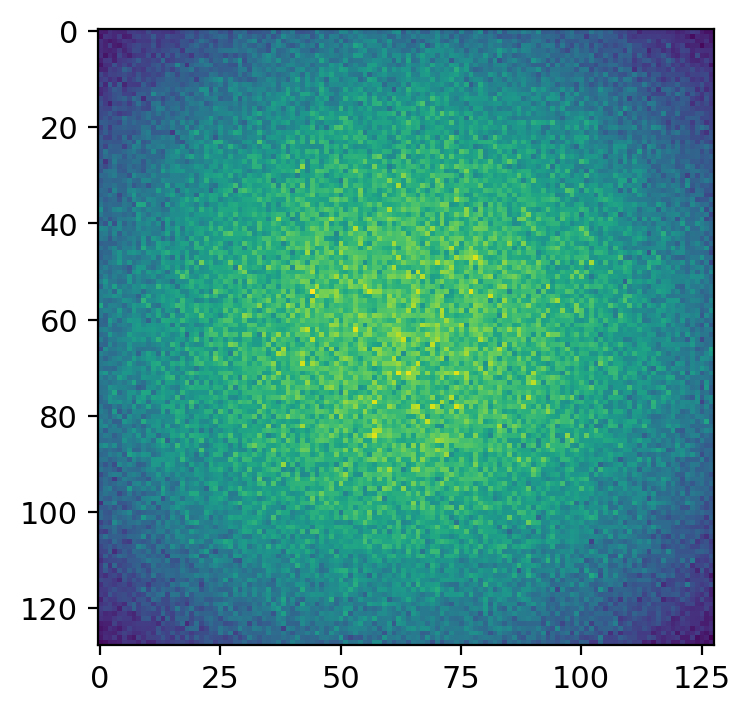

INFO:basicpy.basicpy:=== BaSiC fit started ===
INFO:basicpy.basicpy:lamba_flatfield set to 1.0
INFO:basicpy.basicpy:lamba_darkfield set to 0.01
INFO:basicpy.basicpy:lamba_darkfield_sparse set to 0.0001
INFO:basicpy.basicpy:reweighting iteration 0
INFO:basicpy.basicpy:single-step optimization score: 9.893475407807273e-07.
INFO:basicpy.basicpy:mean of S: 63.822174072265625.
INFO:basicpy.basicpy:Iteration 0 finished.
INFO:basicpy.basicpy:=== BaSiC fit finished in 1.8971543749794364 seconds ===


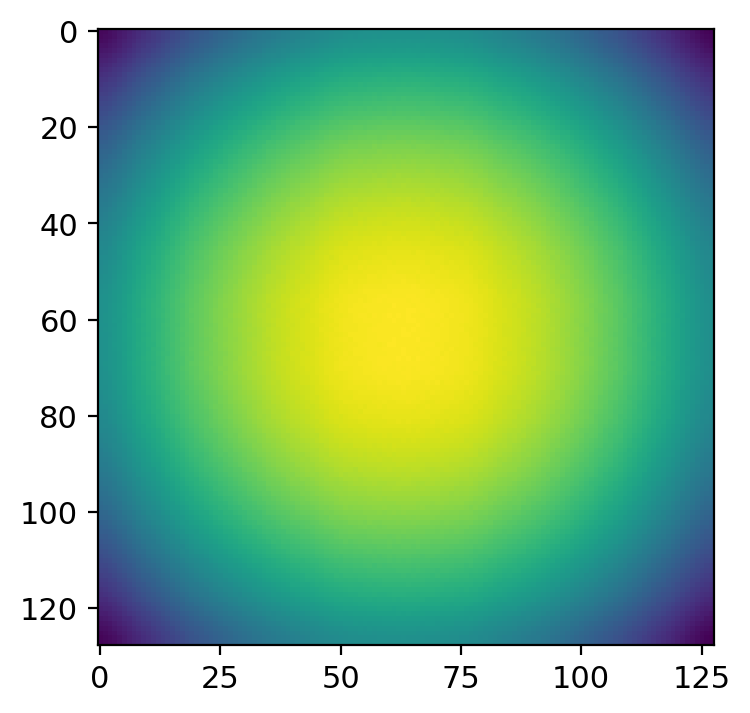

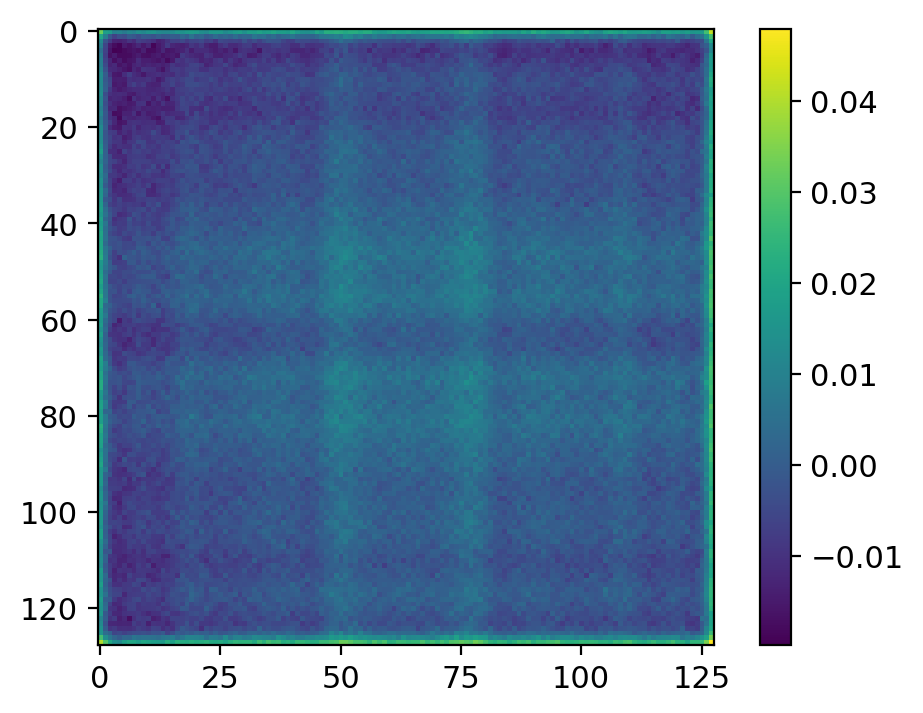

In [4]:
basic = BaSiC(
    get_darkfield=False,
    lambda_flatfield_coef=1,
    max_reweight_iterations=1,
    max_iterations=2000,
)


"""Generate a parabolic gradient to simulate uneven illumination"""
# Create a gradient
n_images = 8
size = basic.working_size
grid = np.meshgrid(*(2 * (np.linspace(-size // 2 + 1, size // 2, size),)))
gradient = sum(d**2 for d in grid)
gradient = 0.01 * (np.max(gradient) - gradient) + 10
gradient_int = gradient.astype(np.uint8)

# Ground truth, for correctness checking
truth = gradient / gradient.mean()

# Create an image stack and add poisson noise
synthetic_images = np.random.poisson(
    lam=gradient_int.flatten(), size=(n_images, size**2)
).reshape((n_images, size, size))
plt.imshow(synthetic_images[0])
plt.show()


"""Fit with BaSiC"""
basic.fit(synthetic_images)
plt.imshow(basic.flatfield)
plt.show()
plt.imshow(basic.flatfield - truth)
plt.colorbar()
plt.show()

# Exporting data for test

In [ ]:
images = {}
keys = [
    "cell_culture",
    "timelapse_brightfield",
    "timelapse_nanog",
    "timelapse_pu1",
    "wsi_brain",
]
for k in keys:
    d = np.load(f"../data/{k}.npz")
    im = d["images"]
    print(im.shape, im.dtype)
    plt.imshow(im[10])
    images[k] = im
    plt.show()

In [ ]:
os.makedirs("../tests/test_basic", exist_ok=True)
os.makedirs("../tests/test_basic/plots", exist_ok=True)

import logging

# logging.getLogger("basicpy").setLevel(level=logging.WARNING)

figsize = 3

for fitting_mode in list(FittingMode)[:]:
    nrows = len(images) * 4
    fig, axes = plt.subplots(
        nrows,
        3,
        figsize=[figsize * 1.5 * 3, figsize * nrows],
        gridspec_kw={"hspace": 0.5, "wspace": 0.5},
    )
    results = []
    for j, ((k, im), (get_darkfield, sort_intensity)) in enumerate(
        product(images.items(), product([False, True], repeat=2))
    ):
        print(j)
        b = BaSiC(
            fitting_mode=fitting_mode,
            lambda_flatfield_coef=0.25,
            get_darkfield=get_darkfield,
            sort_intensity=sort_intensity,
            max_reweight_iterations=1,
            # optimization_tol=1e-9
        )
        b.fit(im / (np.mean(im, axis=(1, 2))[:, np.newaxis, np.newaxis]))
        # b.fit(im)
        for ax, res_im in zip(axes[j], [b.flatfield, b.darkfield]):
            _im = ax.imshow(res_im)
            plt.colorbar(_im, ax=ax)
        axes[j, 2].plot(b.baseline)
        boolstr = lambda x: "with" if x else "without"
        k2 = f"{k}_{fitting_mode.value}_{boolstr(get_darkfield)}-darkfield_{boolstr(sort_intensity)}-sort"
        axes[j, 1].set_title(k2)
        results.append(
            dict(
                image_name=k,
                flatfield=b.flatfield,
                darkfield=b.darkfield,
                baseline=b.baseline,
                params=b.dict(),
            )
        )
        break
    fig.savefig(
        f"../tests/test_basic/plots/{fitting_mode.value}.png", bbox_inches="tight"
    )
    np.savez_compressed(
        f"../tests/test_basic/{fitting_mode.value}.npz", results=results
    )
    break

In [ ]:
plt.imshow(b._weight[0, 0])
plt.colorbar()

In [ ]:
os.makedirs("../tests/test_basic", exist_ok=True)
os.makedirs("../tests/test_basic/plots", exist_ok=True)

import logging

# logging.getLogger("basicpy").setLevel(level=logging.WARNING)

figsize = 3

for fitting_mode in list(FittingMode)[:]:
    nrows = len(images) * 4
    fig, axes = plt.subplots(
        nrows,
        3,
        figsize=[figsize * 1.5 * 3, figsize * nrows],
        gridspec_kw={"hspace": 0.5, "wspace": 0.5},
    )
    results = []
    for j, ((k, im), (get_darkfield, sort_intensity)) in enumerate(
        product(images.items(), product([False, True], repeat=2))
    ):
        print(j)
        b = BaSiC(
            fitting_mode=fitting_mode,
            lambda_flatfield_coef=0.0001,
            get_darkfield=get_darkfield,
            sort_intensity=sort_intensity,
            max_reweight_iterations=1,
            epsilon=1e-12
            # optimization_tol=1e-9
        )
        b.fit(im)
        # b.fit(im)
        for ax, res_im in zip(axes[j], [b.flatfield, b.darkfield]):
            _im = ax.imshow(res_im)
            plt.colorbar(_im, ax=ax)
        axes[j, 2].plot(b.baseline)
        boolstr = lambda x: "with" if x else "without"
        k2 = f"{k}_{fitting_mode.value}_{boolstr(get_darkfield)}-darkfield_{boolstr(sort_intensity)}-sort"
        axes[j, 1].set_title(k2)
        results.append(
            dict(
                image_name=k,
                flatfield=b.flatfield,
                darkfield=b.darkfield,
                baseline=b.baseline,
                params=b.dict(),
            )
        )
        break
    fig.savefig(
        f"../tests/test_basic/plots/{fitting_mode.value}.png", bbox_inches="tight"
    )
    np.savez_compressed(
        f"../tests/test_basic/{fitting_mode.value}.npz", results=results
    )
    break

In [ ]:
plt.imshow(b._weight[0, 0], vmax=0.0001)
plt.colorbar()